# Import Libraries

In [20]:
import pandas as pd
import numpy as np

#Use Keras Neural Network Components. This will be used to construct the LSTM
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

#Import Tensorflow 
import tensorflow as tf

#Import Pytorch
import torch
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import TensorDataset, DataLoader

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion Matrix Library
from sklearn.metrics import confusion_matrix

# Ensure Reproducability of Results

In [21]:
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Fetch and Set Up Data

In [22]:
#Numerically Encode the Activities
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [23]:
DATDIR = "data/UCI HAR Dataset"
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "gravity_acc_x",
    "gravity_acc_y",
    "gravity_acc_z"
    ]

In [24]:
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_raw_signal_data(train_test, signal):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/Inertial Signals/{signal}_{'train' if train_test == 0 else 'test'}.txt"
    return pd.read_csv(file_path, delim_whitespace = True, header = None)

#Same purpose as previous function but, in this case, we are fetching ALL the raw signal data!
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_all_raw_signals(train_test):
    data_raw_signals = []
    for signal in SIGNALS:
        raw_signal_data = fetch_raw_signal_data(train_test, signal).to_numpy()
        data_raw_signals.append(raw_signal_data)
    
    data_raw_signals = np.array(data_raw_signals)
    return np.transpose(data_raw_signals, axes = (1, 2, 0))

#Fetch Labels
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_labels(train_test):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/y_{'train' if train_test == 0 else 'test'}.txt"
    return pd.get_dummies(pd.read_csv(file_path, delim_whitespace=True, header = None)[0]).to_numpy()

In [25]:
X_train, X_test, Y_train, Y_test = fetch_all_raw_signals(0), fetch_all_raw_signals(1), fetch_labels(0), fetch_labels(1)

N = X_train.shape[0]
T = X_train.shape[1]
D1 = X_train.shape[2]

print(N, T, D1)

n_classes = Y_train.shape[1]
print(n_classes)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

7352 128 9
6
(7352, 128, 9) (2947, 128, 9) (7352, 6) (2947, 6)


# Define Transformer Architecture

In [26]:
class TransformerModel(nn.Module):
    def __init__(self, D2, H, L):
        super().__init__()
        
        #Take the Raw Inertial Samples and Embed them in a Higher Dimension
        self.convolution_series = nn.Sequential(
            nn.Conv1d(D1, D2, 1), nn.GELU(),
            nn.Conv1d(D2, D2, 1), nn.GELU(),
            nn.Conv1d(D2, D2, 1), nn.GELU(),
            nn.Conv1d(D2, D2, 1), nn.GELU())
        
        #Generate an Embedding for each position in the input sequence
        self.position_embedding = nn.Parameter(torch.randn(T + 1, 1, D2))
        
        #Transformer Encoder[Comprised of Self Multi-Head Attention and FC Network]
        self.encoder_layer = TransformerEncoderLayer(d_model = D2, nhead = H, dim_feedforward = 2 * D2, dropout = 0.1, activation = "relu")
        
        #Stack together those EncoderLayers to form the TransformerEncoder
        #The TransformerEncoder will use L TransformerEncoderLayer units
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, L)
        
        #Class Token
        self.cls_token = nn.Parameter(torch.zeros((1, D2)), requires_grad=True)
        
        #FC Stuff at the End
        self.classifier_head = nn.Sequential(
            nn.LayerNorm(D2),
            nn.Linear(D2, D2//4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(D2//4,  n_classes)
        )
    
    #Run forward pass given X(input data)
    #Shape of X: N x T x D1
    def forward(self, X):
        #First do the higher dimensional embedding
        X = self.convolution_series(X.transpose(1, 2)).permute(2, 0, 1)
        
        #Generate class token
        cls_token = self.cls_token.unsqueeze(1).repeat(1, X.shape[1], 1)
        X = torch.cat([cls_token, X])
        
        #Add Positional Embedding
        X += self.position_embedding
        
        #Run through the Transformer Encoder
        target = self.transformer_encoder(X)[0]
        
        #Get Class Probabilities
        target = self.classifier_head(target)
        
        return target

In [27]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(X_train_tensor, Y_train_tensor)

# Batch Size
batch_size = 512

# Create a DataLoader
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

model = TransformerModel(D2 = 12, H = 4, L = 6)

#Set up loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer and scheduler
optim = torch.optim.Adam(model.parameters(), lr = 0.01)

#Set number of epochs
num_epochs = 25

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    batch_idx = 0
    for batch in train_loader:
        inputs, targets = batch

        # Zero the gradients
        optim.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update the model parameters
        optim.step()
    
        print(f"EPOCH:{epoch+1}, BATCH: {batch_idx+1}, Loss:{loss.item()}")
        batch_idx += 1
        

/Users/raviraghavan/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EPOCH:1, BATCH: 1, Loss:2.0049283504486084
EPOCH:1, BATCH: 2, Loss:1.900481939315796
EPOCH:1, BATCH: 3, Loss:1.8676722049713135
EPOCH:1, BATCH: 4, Loss:1.8772635459899902
EPOCH:1, BATCH: 5, Loss:1.8932846784591675
EPOCH:1, BATCH: 6, Loss:1.855940818786621
EPOCH:1, BATCH: 7, Loss:1.8616342544555664
EPOCH:1, BATCH: 8, Loss:1.8483017683029175
EPOCH:1, BATCH: 9, Loss:1.8370373249053955
EPOCH:1, BATCH: 10, Loss:1.870314359664917
EPOCH:1, BATCH: 11, Loss:1.8437457084655762
EPOCH:1, BATCH: 12, Loss:1.8400954008102417
EPOCH:1, BATCH: 13, Loss:1.8618113994598389
EPOCH:1, BATCH: 14, Loss:1.858811616897583
EPOCH:1, BATCH: 15, Loss:1.8167580366134644
EPOCH:2, BATCH: 1, Loss:1.8372082710266113
EPOCH:2, BATCH: 2, Loss:1.846779227256775
EPOCH:2, BATCH: 3, Loss:1.8352608680725098
EPOCH:2, BATCH: 4, Loss:1.8189892768859863
EPOCH:2, BATCH: 5, Loss:1.8166556358337402
EPOCH:2, BATCH: 6, Loss:1.8218929767608643
EPOCH:2, BATCH: 7, Loss:1.8110244274139404
EPOCH:2, BATCH: 8, Loss:1.8213298320770264
EPOCH:2, B

In [28]:
# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Batch Size
batch_size = 256

# Create a DataLoader
test_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

# Initialize variables for evaluation
total_correct = 0
total_samples = 0

#Store predicted and ground truth
predicted_values = []
ground_truth = []

# Disable gradient computation during testing
with torch.no_grad():
    # Set the model to evaluation mode
    model.eval()

    for inputs, targets in test_loader:
        # Forward pass
        outputs = model(inputs)

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        _, actual = torch.max(targets, 1)
                
        predicted_values = predicted_values + predicted.tolist()
        ground_truth = ground_truth + actual.tolist()
        
        # Update evaluation statistics
        total_samples += targets.size(0)
        total_correct += (predicted == actual).sum().item()

# Calculate accuracy
accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 36.17%


In [29]:
normalized_cm = confusion_matrix(ground_truth, predicted_values, normalize = 'true')

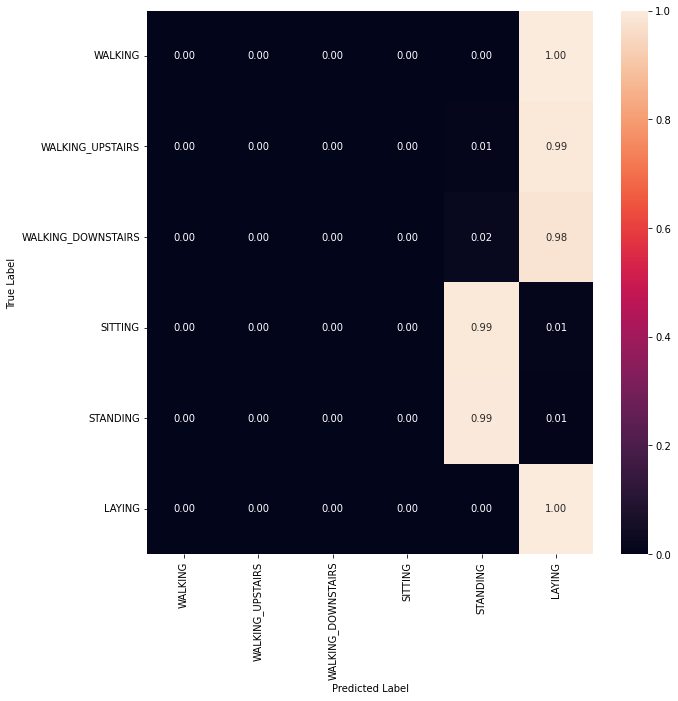

In [30]:
#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)